# Bigram Language Model

In [83]:
words = open("names.txt").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [84]:
b = {}
for word in words:
    chs = ["<S>"] + list(word) + ["<E>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1
        
sorted(b.items(), key = lambda kv: kv[1], reverse = True)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

## Approach 1: Count-based Learning

In [85]:
import torch

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

N = torch.zeros((27, 27), dtype=torch.int32)

for word in words:
    chs = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        N[idx1, idx2] += 1

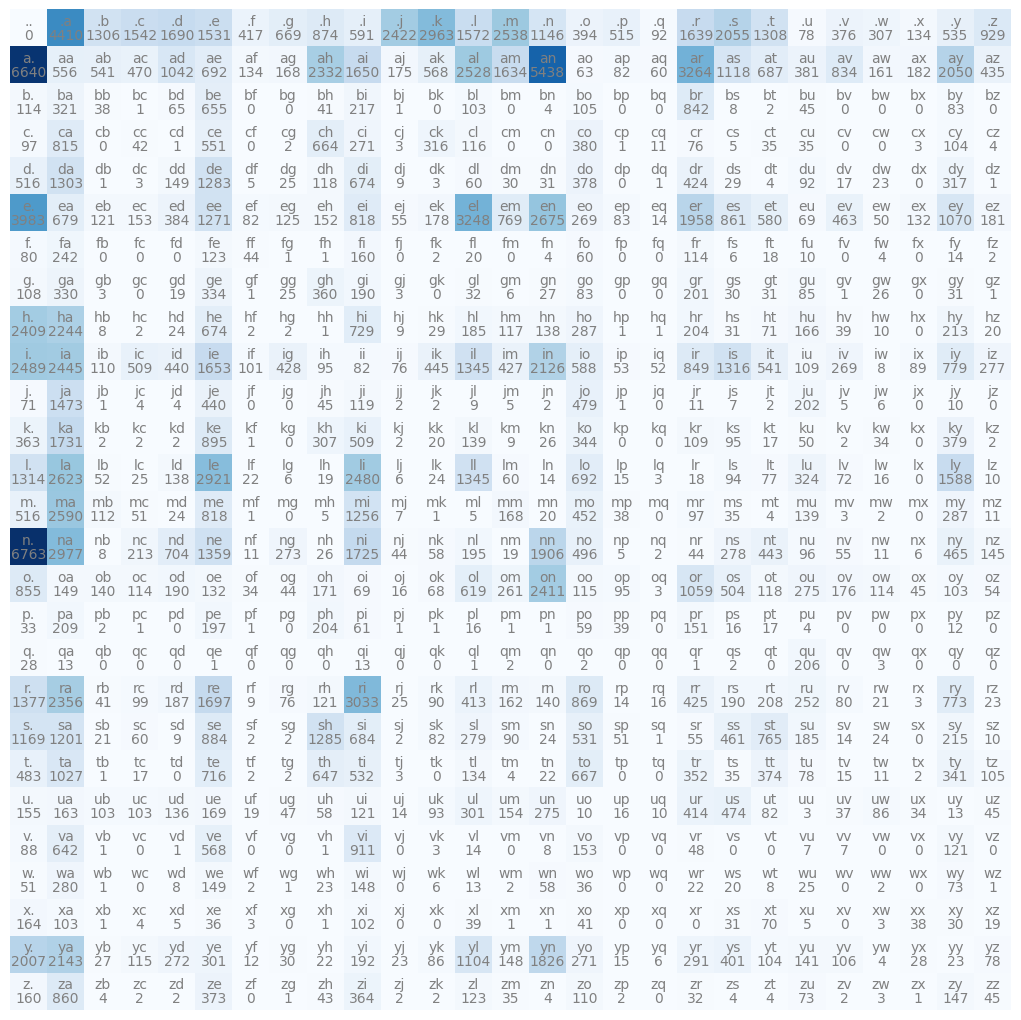

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(13,13))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [ ]:
g = torch.Generator().manual_seed(2147483647)

P = (N).float()
# passing dim=1 means, dim=1 will be squezed into 1 dim, performing the sum operation
P /= torch.sum(P, dim=1, keepdim=True) # /= for extra efficiency, <dim and keepdim>!

for i in range(20):
    out = []
    ix = 0
    while True:
        p = P[ix]
        # p = torch.ones((27)) / 27.0
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        char = itos[ix]
        out.append(char)
        if ix == 0:
            break
        
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
ka.
emimmsade.
enkaviyny.
ftlspihinivenvorhlasu.
dsor.
br.
jol.
pen.
aisan.
ja.


In [88]:
# calculate loss (for all words)
# add smoothing and compare the loss

log_likelihood = 0.0
n = 1

for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        prob = P[stoi[ch1], stoi[ch2]]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

print(f"nll: {-log_likelihood / n}") # nll: 2.4540834426879883

# note: 'andrej' vs 'andrejq' and smoothing

nll: 2.4540834426879883


## Approach 2: Gradient-based Learning

In [92]:
# build a gradient based approach
# model smoothing as regularization loss (l2 regularization)
# sampling from NN and compare the result

import torch
import torch.nn.functional as F

xs = []
ys = []

for word in words:
    chs = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        xs.append(idx1)
        ys.append(idx2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

g = torch.Generator().manual_seed(2147483647)
W = torch.rand((27, 27), generator=g, requires_grad=True)

num = xs.nelement()

In [98]:
for _ in range(100):
    xonehot = F.one_hot(xs, num_classes = 27).float()

    # logits: output of the network (forward pass)
    logits = xonehot @ W

    # softmax (normalization)
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)

    # loss
    loss = -probs[torch.arange(num), ys].log().mean()
    print(loss.item())
    
    # backward
    W.grad = None
    loss.backward()
    
    # update
    W.data += -0.1 * W.grad

2.5007708072662354
2.5007686614990234
2.5007662773132324
2.5007636547088623
2.500761032104492
2.5007588863372803
2.500756025314331
2.50075364112854
2.500751256942749
2.5007483959198
2.500746250152588
2.500743865966797
2.5007410049438477
2.5007386207580566
2.5007359981536865
2.5007336139678955
2.5007309913635254
2.5007286071777344
2.5007259845733643
2.5007238388061523
2.500720977783203
2.500718355178833
2.500716209411621
2.500713348388672
2.500710964202881
2.5007083415985107
2.500706195831299
2.5007035732269287
2.5007009506225586
2.5006985664367676
2.5006959438323975
2.5006935596466064
2.5006909370422363
2.500688314437866
2.500685930252075
2.500683307647705
2.500680923461914
2.500678300857544
2.500676155090332
2.500673294067383
2.500670909881592
2.500668525695801
2.5006656646728516
2.5006635189056396
2.5006611347198486
2.5006582736968994
2.5006558895111084
2.5006537437438965
2.5006508827209473
2.5006487369537354
2.500645875930786
2.500643491744995
2.500640869140625
2.500638246536255
2.5

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    output = []
    idx = 0
    while True:
        xenc = F.one_hot(torch.tensor([idx]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)
        
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        output.append(itos[idx])
        if idx == 0:
            break
    print(''.join(output)) # could give different results if the network is not fully trained

cexze.
momasurailezityha.
kanimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavugie.
teda.
ka.
emia.
sade.
enkaviyny.
ftbspmhinivenvtahlasu.
dsdr.
br.
jol.
pyawaisan.
ja.
fdinen.


## Exercises

### E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

#### 1) 2D Count-based Approach

In [209]:
import torch

words = open("names.txt").read().splitlines()

a = ord('a')
alps = ['.'] + [chr(idx) for idx in range(a, a+26)]

alptoi = {s:i for i,s in enumerate(alps)}
itoalp = {i:s for s,i in alptoi.items()}

# preparing the dataset
perms = []
for first_alp in alps:
    for second_alp in alps:
        perms.append(first_alp + second_alp)
        
stoi = {s:i for i,s in enumerate(perms)}
itos = {i:s for s,i in stoi.items()}

# training
N = torch.zeros((27*27, 27), dtype=torch.int32)

total = 0

for word in words:
    chs = ['.', '.'] + list(word) + ['.']
    for idx in range(2, len(chs)):
        key = chs[idx-2] + chs[idx-1] # two characters
        following = chs[idx] # a following character
        row = stoi[key]
        col = alptoi[following]
        N[row, col] += 1
        total += 1
        
# sampling
a = ord('a')
atoz = [chr(idx) for idx in range(a, a+26)]

P = (N+1).float()
P = P / P.sum(dim=1, keepdim=True)

g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    output = []
    initial = '..'
    # print(f"starting with: {initial}")
    while True:
        dist = P[stoi[initial]]
        idx = torch.multinomial(dist, num_samples=1, replacement=True, generator=g).item()
        # print(f"next char sampled: {itoalp[idx]}")
        output.append(itoalp[idx])
        initial = initial[-1] + itoalp[idx]
        # print(f"next initial becomes: {initial}")
        if idx == 0:
            break
    print(''.join(output))
    
# calculating loss
log_likelihood = 0.0
n = 1

for word in words:
    chs = ['.', '.'] + list(word) + ['.']
    for idx in range(2, len(chs)):
        initial = chs[idx-2] + chs[idx-1]
        following = chs[idx]
        row = stoi[initial]
        col = alptoi[following]
        prob = P[row, col]
        log_prob = prob.log()
        log_likelihood += log_prob
        n += 1
print(f"nll loss: {-log_likelihood / n}")

ce.
bra.
jalius.
rochityharlonimittain.
luwak.
ka.
da.
samiyah.
javer.
gotai.
nll loss: 2.2119641304016113


#### 2) 3D Count-based Approach

In [210]:
# 3D count-based approach

words = open("names.txt").read().splitlines()

a = ord('a')
alps = ['.'] + [chr(i) for i in range(a, a+26)]

stoi = {s:i for i,s in enumerate(alps)}
itos = {i:s for s,i in stoi.items()}

# building the count and the prob matrix
N = torch.zeros((27, 27, 27), dtype=torch.int32)

for word in words:
    chs = ['.', '.'] + list(word) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        idx1, idx2, idx3 = stoi[ch1], stoi[ch2], stoi[ch3]
        N[idx1, idx2, idx3] += 1
        
P = (N+1).float()
P = P / P.sum(dim=2, keepdim=True)

# sampling
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    output = []
    ch1 = '.'
    ch2 = '.'
    while True:
        p = P[stoi[ch1], stoi[ch2], :] # sum to 1
        idx3 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        ch3 = itos[idx3]
        output.append(ch3)
        ch1 = ch2
        ch2 = ch3
        if idx3 == 0:
            break
    print(''.join(output))

# calculating the loss
log_likelihood = 0.0
count = 0

for word in words:
    chs = ['.', '.'] + list(word) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        idx1, idx2, idx3 = stoi[ch1], stoi[ch2], stoi[ch3]
        prob = P[idx1, idx2, idx3]
        log_likelihood += torch.log(prob) 
        count += 1

print(f'nll loss: {-log_likelihood / count}')

ce.
bra.
jalius.
rochityharlonimittain.
luwak.
ka.
da.
samiyah.
javer.
gotai.
nll loss: 2.2119739055633545


#### 3) Gradient-based Approach with 27 * 27 dim

In [7]:
import torch
import torch.nn.functional as F

words = open("names.txt").read().splitlines()

a = ord('a')
alps = ['.'] + [chr(idx) for idx in range(a, a+26)]

alptoi = {s:i for i,s in enumerate(alps)}
itoalp = {i:s for s,i in alptoi.items()}

perms = []
for first_alp in alps:
    for second_alp in alps:
        perms.append(first_alp + second_alp)
        
stoi = {s:i for i,s in enumerate(perms)}
itos = {i:s for s,i in stoi.items()}

# preparing dataset
xs, ys = [], []

for word in words:
    chs = ['.', '.'] + list(word) + ['.']
    for idx in range(2, len(chs)):
        initial = chs[idx-2] + chs[idx-1]
        following = chs[idx]
        xs.append(stoi[initial])
        ys.append(alptoi[following])
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

n = xs.nelement()

# training
g = torch.Generator().manual_seed(2147483647)
W = torch.rand((27*27, 27), generator=g, requires_grad=True)

for iter in range(1000):
    xenc = F.one_hot(xs, num_classes=27*27).float()
    
    # forward
    logits = xenc @ W
    
    # calculate the loss
    counts = torch.exp(logits)
    probs = counts / counts.sum(dim=1, keepdim=True)
    loss = -probs[torch.arange(n), ys].log().mean()
    if iter % 50 == 0:
        print(loss)
        
    # backward
    W.grad = None
    loss.backward()
    
    # update
    W.data += -10* W.grad

tensor(3.3533, grad_fn=<NegBackward0>)
tensor(2.9386, grad_fn=<NegBackward0>)
tensor(2.7660, grad_fn=<NegBackward0>)
tensor(2.6690, grad_fn=<NegBackward0>)
tensor(2.6043, grad_fn=<NegBackward0>)
tensor(2.5570, grad_fn=<NegBackward0>)
tensor(2.5207, grad_fn=<NegBackward0>)
tensor(2.4916, grad_fn=<NegBackward0>)
tensor(2.4678, grad_fn=<NegBackward0>)
tensor(2.4479, grad_fn=<NegBackward0>)
tensor(2.4309, grad_fn=<NegBackward0>)
tensor(2.4162, grad_fn=<NegBackward0>)
tensor(2.4033, grad_fn=<NegBackward0>)
tensor(2.3920, grad_fn=<NegBackward0>)
tensor(2.3818, grad_fn=<NegBackward0>)
tensor(2.3728, grad_fn=<NegBackward0>)
tensor(2.3645, grad_fn=<NegBackward0>)
tensor(2.3571, grad_fn=<NegBackward0>)
tensor(2.3503, grad_fn=<NegBackward0>)
tensor(2.3440, grad_fn=<NegBackward0>)


In [8]:
# sampling
a = ord('a')
atoz = [chr(idx) for idx in range(a, a+26)]

g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    output = []
    initial = '..'
    # print(f"starting with: {initial}")
    while True:
        x = torch.tensor([stoi[initial]])
        xenc = F.one_hot(x, num_classes=27*27).float()
        logits = xenc @ W
        count = logits.exp()
        probs = count / count.sum(dim=1, keepdim=True)
        
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        # print(f"next char sampled: {itoalp[idx]}")
        output.append(itoalp[idx])
        initial = initial[-1] + itoalp[idx]
        # print(f"next initial becomes: {initial}")
        if idx == 0:
            break
    print(''.join(output))

cexbmkzogpkurkimarityhwevinimjttain.
luwakzkktdr.
samiyaubjtvhrighton.
moziellavojzwpteda.
kaley.
masideu.
niavion.
rftbspmhwcivenvtallasu.
dsdxxblnwglhpyiw.
isan.


#### 4) Gradient-based Approach with 27 + 27 dim

In [9]:
import torch
import torch.nn.functional as F

words = open("names.txt").read().splitlines()

a = ord('a')
alps = ['.'] + [chr(i) for i in range(a, a+26)]

stoi = {s:i for i,s in enumerate(alps)}
itos = {i:s for s,i in stoi.items()}

# preparing the dataset
xs1 = []
xs2 = []
ys = []

for word in words:
    chs = ['.', '.'] + list(word) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        xs1.append(stoi[ch1])
        xs2.append(stoi[ch2])
        ys.append(stoi[ch3])

xs1 = torch.tensor(xs1)
xs2 = torch.tensor(xs2)
ys = torch.tensor(ys)

n = ys.nelement()

# training the network
g = torch.Generator().manual_seed(2147483647)
W = torch.rand((27+27, 27), generator=g, requires_grad=True)

for iter in range(1000):
    xenc = torch.cat((F.one_hot(xs1, num_classes=27), F.one_hot(xs2, num_classes=27)), dim=1).float() # TODO: does this have to be in the loop?
    logit = xenc @ W
    count = torch.exp(logit)
    prob = count / count.sum(dim=1, keepdim=True)
    loss = -prob[torch.arange(n), ys].log().mean()
    if iter % 50 == 0:
        print(loss)
    
    W.grad = None
    loss.backward()
    
    W.data += -5 * W.grad

tensor(3.4334, grad_fn=<NegBackward0>)
tensor(2.5863, grad_fn=<NegBackward0>)
tensor(2.4861, grad_fn=<NegBackward0>)
tensor(2.4455, grad_fn=<NegBackward0>)
tensor(2.4228, grad_fn=<NegBackward0>)
tensor(2.4082, grad_fn=<NegBackward0>)
tensor(2.3978, grad_fn=<NegBackward0>)
tensor(2.3901, grad_fn=<NegBackward0>)
tensor(2.3842, grad_fn=<NegBackward0>)
tensor(2.3794, grad_fn=<NegBackward0>)
tensor(2.3754, grad_fn=<NegBackward0>)
tensor(2.3721, grad_fn=<NegBackward0>)
tensor(2.3693, grad_fn=<NegBackward0>)
tensor(2.3669, grad_fn=<NegBackward0>)
tensor(2.3648, grad_fn=<NegBackward0>)
tensor(2.3629, grad_fn=<NegBackward0>)
tensor(2.3613, grad_fn=<NegBackward0>)
tensor(2.3598, grad_fn=<NegBackward0>)
tensor(2.3585, grad_fn=<NegBackward0>)
tensor(2.3573, grad_fn=<NegBackward0>)


In [13]:
# sampling from the learned weights
g = torch.Generator().manual_seed(2147483647)

for _ in range(10):
    output = []
    ch1 = '.'
    ch2 = '.'
    while True:
        xs1 = torch.tensor([stoi[ch1]])
        xs2 = torch.tensor([stoi[ch2]])
        
        xenc = torch.cat((F.one_hot(xs1, num_classes=27), F.one_hot(xs2, num_classes=27)), dim=1).float()
        logit = xenc @ W
        count = torch.exp(logit)
        prob = count / count.sum(dim=1, keepdim=True)
        idx = torch.multinomial(prob, num_samples= 1, replacement=True, generator=g).item()
        
        next_chr = itos[idx]
        output.append(next_chr)
        
        ch1 = ch2
        ch2 = next_chr
        
        if idx == 0:
            break
    print(''.join(output))

cexze.
morlyurailazitynn.
konish.
tain.
lusan.
ka.
da.
samiyaubrtthrigotai.
morielliau.
ke.


### Loss Summary

**Bigram**
- loss: ~2.4

**Trigram**
- count-based approaches: 2.2119641304016113
- gradient-based approach with 27 * 27: ~2.3
- gradient-based approach with 27 + 27: ~2.3

### E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?  

#### funtionalize ngram approaches

In [ ]:
import torch

def run_count_ngram(n, train, alpha = 1):
    chars = sorted(list(set(''.join(train))))
    stoi = {s:i+1 for i, s in enumerate(chars)}
    stoi['.'] = 0

    N = torch.zeros((27, ) * n, dtype=torch.int32)

    for word in train:
        chs = ["."] * (n-1) + list(word) + ["."]
        for tup in zip(*[chs[i:] for i in range(n)]):
            idxs = tuple(stoi[ch] for ch in tup)
            N[idxs] += 1

    P = (N + alpha).float()
    P /= torch.sum(P, dim=n-1, keepdim=True)
    return P
        
def get_count_ngram_loss(P, dev):
    log_likelihood = 0.0
    total = 1
    
    for word in dev:
        chs = ["."] * (n-1) + list(word) + ["."]
        for tup in zip(*[chs[i:] for i in range(n)]):
            idxs = tuple(stoi[ch] for ch in tup)
            prob = P[idxs]
            logprob = torch.log(prob)
            log_likelihood += logprob
            total += 1
    loss = -log_likelihood / total
    return loss

#### functionalize bigram gradient approach

In [ ]:
import torch
import torch.nn.functional as F

from tqdm import tqdm

def _prepare_bigram_dataset(words):
    xs = []
    ys = []

    for word in words:
        chs = ['.'] + list(word) + ['.']
        for ch1, ch2 in zip(chs, chs[1:]):
            idx1 = stoi[ch1]
            idx2 = stoi[ch2]
            xs.append(idx1)
            ys.append(idx2)
            
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

def run_gradient_bigram(train, epoch, alpha=0.01, lr=0.1):
    xs, ys = _prepare_bigram_dataset(train) 
    total = xs.nelement()
    
    g = torch.Generator().manual_seed(2147483647)
    W = torch.rand((27, 27), generator=g, requires_grad=True)

    for iter in tqdm(range(epoch), total=epoch, desc='training bigram model'):
        xonehot = F.one_hot(xs, num_classes = 27).float()

        # logits: output of the network (forward pass)
        logits = xonehot @ W

        # softmax (normalization)
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)

        # loss
        loss = -probs[torch.arange(total), ys].log().mean() + alpha * (W**2).mean()
        # if iter % 100 == 0:
        #     print(loss.item())
        
        # backward
        W.grad = None
        loss.backward()
        
        # update
        W.data += -lr * W.grad
    return W

def get_gradient_bigram_loss(W, dev):
    xs, ys = _prepare_bigram_dataset(dev)
    total = ys.nelement()
    
    xenc = F.one_hot(xs, num_classes=27).float()
    logit = xenc @ W
    count = torch.exp(logit)
    prob = count / count.sum(dim=1, keepdim=True)
    loss = -prob[torch.arange(total), ys].log().mean().item()
    return loss


# W = run_gradient_bigram(train, alpha=0.01)
# dev_loss = get_gradient_bigram_loss(W, dev)
    

#### funtionalize trigram gradient approach (27 + 27)

In [ ]:
import torch
import torch.nn.functional as F

from tqdm import tqdm

def _prepare_trigram_dataset(words):
    a = ord('a')
    alps = ['.'] + [chr(i) for i in range(a, a+26)]

    stoi = {s:i for i,s in enumerate(alps)}

    xs1 = []
    xs2 = []
    ys = []

    for word in words:
        chs = ['.', '.'] + list(word) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            xs1.append(stoi[ch1])
            xs2.append(stoi[ch2])
            ys.append(stoi[ch3])

    xs1 = torch.tensor(xs1)
    xs2 = torch.tensor(xs2)
    ys = torch.tensor(ys)
    return xs1, xs2, ys


def run_gradient_trigram(train, epoch, alpha=0.01, lr=10):
    xs1, xs2, ys = _prepare_trigram_dataset(train)
    total = ys.nelement()

    # training the network
    g = torch.Generator().manual_seed(2147483647)
    W = torch.rand((27+27, 27), generator=g, requires_grad=True)

    for iter in tqdm(range(epoch), total=epoch, desc='training trigram model'):
        xenc = torch.cat((F.one_hot(xs1, num_classes=27), F.one_hot(xs2, num_classes=27)), dim=1).float() # TODO: does this have to be in the loop?
        logit = xenc @ W
        count = torch.exp(logit)
        prob = count / count.sum(dim=1, keepdim=True)
        loss = -prob[torch.arange(total), ys].log().mean() + alpha * (W**2).mean()
        # if iter % 100 == 0:
        #     print(loss.item())
        
        W.grad = None
        loss.backward()
        
        W.data += -lr * W.grad
    return W
        
def get_gradient_trigram_loss(W, dev):
    xs1, xs2, ys = _prepare_trigram_dataset(dev)
    total = ys.nelement()
    
    xenc = torch.cat((F.one_hot(xs1, num_classes=27), F.one_hot(xs2, num_classes=27)), dim=1).float()
    logit = xenc @ W
    count = torch.exp(logit)
    prob = count / count.sum(dim=1, keepdim=True)
    loss = -prob[torch.arange(total), ys].log().mean().item()
    return loss

In [141]:
import random

words = open("names.txt").read().splitlines()
random.shuffle(words)

train = words[:int(len(words) * 0.8)]
dev = words[int(len(words) * 0.8):int(len(words) * 0.8)+int(len(words) * 0.1)]
test = words[int(len(words) * 0.8)+int(len(words) * 0.1):]

bigram_model = run_gradient_bigram(train, epoch=500, lr=10)
train_loss = get_gradient_bigram_loss(bigram_model, train)
dev_loss = get_gradient_bigram_loss(bigram_model, dev)
test_loss = get_gradient_bigram_loss(bigram_model, test)
print(f'[bigram] train: {train_loss}, dev: {dev_loss}, test: {test_loss}')

trigram_model = run_gradient_trigram(train, epoch=500, lr=10)
train_loss = get_gradient_trigram_loss(trigram_model, train)
dev_loss = get_gradient_trigram_loss(trigram_model, dev)
test_loss = get_gradient_trigram_loss(trigram_model, test)
print(f'[trigram] train: {train_loss}, dev: {dev_loss}, test: {test_loss}')

training bigram model: 100%|██████████| 500/500 [00:11<00:00, 44.86it/s]


[bigram] train: 2.471539258956909, dev: 2.478808879852295, test: 2.4841010570526123


training trigram model: 100%|██████████| 500/500 [00:18<00:00, 27.27it/s]


[trigram] train: 2.35503888130188, dev: 2.365537166595459, test: 2.373016119003296


### E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

In [155]:
import numpy as np

alphas = [0, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1]

best_model = None
best_alpha = None
best_dev_loss = np.inf

for alpha in alphas:
    trigram_model = run_gradient_trigram(train, epoch=200, lr=10, alpha=alpha)
    train_loss = get_gradient_trigram_loss(trigram_model, train)
    dev_loss = get_gradient_trigram_loss(trigram_model, dev)
    if dev_loss < best_dev_loss: 
        best_model = trigram_model
        best_dev_loss = dev_loss
        best_alpha = alpha
    print(f'[trigram] alpha: {alpha}, train: {train_loss}, dev: {dev_loss}')

test_loss = get_gradient_bigram_loss(best_model, test)
print(f'[best] alpha: {best_alpha}, test: {test_loss}')

training trigram model: 100%|██████████| 200/200 [00:06<00:00, 28.77it/s]


[trigram] alpha: 0, train: 2.3817477226257324, dev: 2.3926661014556885


training trigram model: 100%|██████████| 200/200 [00:06<00:00, 30.21it/s]


[trigram] alpha: 0.0005, train: 2.3817882537841797, dev: 2.392702341079712


training trigram model: 100%|██████████| 200/200 [00:06<00:00, 30.47it/s]


[trigram] alpha: 0.001, train: 2.381829023361206, dev: 2.3927385807037354


training trigram model: 100%|██████████| 200/200 [00:06<00:00, 30.51it/s]


[trigram] alpha: 0.005, train: 2.382157325744629, dev: 2.393031120300293


training trigram model: 100%|██████████| 200/200 [00:06<00:00, 30.20it/s]


[trigram] alpha: 0.01, train: 2.382572889328003, dev: 2.3934032917022705


training trigram model: 100%|██████████| 200/200 [00:06<00:00, 28.63it/s]


[trigram] alpha: 0.02, train: 2.3834242820739746, dev: 2.3941683769226074


training trigram model: 100%|██████████| 200/200 [00:07<00:00, 28.55it/s]


[trigram] alpha: 0.05, train: 2.3861172199249268, dev: 2.3966143131256104


training trigram model: 100%|██████████| 200/200 [00:06<00:00, 30.06it/s]


[trigram] alpha: 0.1, train: 2.3909919261932373, dev: 2.401111125946045


training trigram model: 100%|██████████| 200/200 [00:06<00:00, 30.37it/s]


[trigram] alpha: 0.5, train: 2.436161518096924, dev: 2.4442272186279297


training trigram model: 100%|██████████| 200/200 [00:06<00:00, 30.38it/s]


[trigram] alpha: 1, train: 2.488835573196411, dev: 2.4954614639282227
[best] alpha: 0, test: 2.9702374935150146


### E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?  

#### indexing for the bigram model

In [158]:
g = torch.Generator().manual_seed(2147483647)

def new_run_gradient_bigram(train, epoch, alpha=0.01, lr=0.1):
    xs, ys = _prepare_bigram_dataset(train) 
    total = xs.nelement()
    
    g = torch.Generator().manual_seed(2147483647)
    W = torch.rand((27, 27), generator=g, requires_grad=True)

    for iter in tqdm(range(epoch), total=epoch, desc='training bigram model'):
        # logits: output of the network (forward pass)
        logits = W[xs, :]

        # softmax (normalization)
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)

        # loss
        loss = -probs[torch.arange(total), ys].log().mean() + alpha * (W**2).mean()
        
        # backward
        W.grad = None
        loss.backward()
        
        # update
        W.data += -lr * W.grad
    return W

def new_get_gradient_bigram_loss(W, dev):
    xs, ys = _prepare_bigram_dataset(dev)
    total = ys.nelement()
    
    logit = W[xs, :]
    count = torch.exp(logit)
    prob = count / count.sum(dim=1, keepdim=True)
    loss = -prob[torch.arange(total), ys].log().mean().item()
    return loss

#### Indexing for the trigram model

In [173]:
g = torch.Generator().manual_seed(2147483647)

def new_run_gradient_trigram(train, epoch, alpha=0.01, lr=10):
    xs1, xs2, ys = _prepare_trigram_dataset(train)
    total = ys.nelement()

    # training the network
    g = torch.Generator().manual_seed(2147483647)
    W = torch.rand((27+27, 27), generator=g, requires_grad=True)

    for iter in tqdm(range(epoch), total=epoch, desc='training trigram model'):
        logit = W[xs1, :] + W[xs2 + 27, :]
        count = torch.exp(logit)
        prob = count / count.sum(dim=1, keepdim=True)
        loss = -prob[torch.arange(total), ys].log().mean() + alpha * (W**2).mean()
        # if iter % 100 == 0:
        #     print(loss.item())
        
        W.grad = None
        loss.backward()
        
        W.data += -lr * W.grad
    return W
        
def new_get_gradient_trigram_loss(W, dev):
    xs1, xs2, ys = _prepare_trigram_dataset(dev)
    total = ys.nelement()
    
    logit = W[xs1, :] + W[xs2 + 27, :]
    count = torch.exp(logit)
    prob = count / count.sum(dim=1, keepdim=True)
    loss = -prob[torch.arange(total), ys].log().mean().item()
    return loss

#### testing the bigram model

In [175]:
# (bigram) with one-hot encoding
bigram_model = run_gradient_bigram(train, epoch=200, lr=10, alpha=0.0)
train_loss = get_gradient_bigram_loss(bigram_model, train)
dev_loss = get_gradient_bigram_loss(bigram_model, dev)
print(f'[bigram] alpha: {alpha}, train: {train_loss}, dev: {dev_loss}')

# (bigram) with tensor indexing
bigram_model = new_run_gradient_bigram(train, epoch=200, lr=10, alpha=0.0)
train_loss = new_get_gradient_bigram_loss(bigram_model, train)
dev_loss = new_get_gradient_bigram_loss(bigram_model, dev)
print(f'[bigram] alpha: {alpha}, train: {train_loss}, dev: {dev_loss}')

training bigram model: 100%|██████████| 200/200 [00:04<00:00, 40.24it/s]


[bigram] alpha: 1, train: 2.4961979389190674, dev: 2.5033864974975586


training bigram model: 100%|██████████| 200/200 [00:04<00:00, 44.40it/s]


[bigram] alpha: 1, train: 2.4961979389190674, dev: 2.5033864974975586


#### testing the trigram model

In [176]:
# (trigram) with one-hot encoding
trigram_model = run_gradient_trigram(train, epoch=200, lr=10, alpha=0.0)
train_loss = get_gradient_trigram_loss(trigram_model, train)
dev_loss = get_gradient_trigram_loss(trigram_model, dev)
print(f'[trigram] alpha: {alpha}, train: {train_loss}, dev: {dev_loss}')

# (trigram) with tensor indexing
trigram_model = new_run_gradient_trigram(train, epoch=200, lr=10, alpha=0.0)
train_loss = new_get_gradient_trigram_loss(trigram_model, train)
dev_loss = new_get_gradient_trigram_loss(trigram_model, dev)
print(f'[trigram] alpha: {alpha}, train: {train_loss}, dev: {dev_loss}')

training trigram model: 100%|██████████| 200/200 [00:07<00:00, 25.72it/s]


[trigram] alpha: 1, train: 2.3817477226257324, dev: 2.3926661014556885


training trigram model: 100%|██████████| 200/200 [00:07<00:00, 27.52it/s]


[trigram] alpha: 1, train: 2.3817477226257324, dev: 2.3926658630371094


### E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

#### CE for the trigram model

In [178]:
g = torch.Generator().manual_seed(2147483647)

def ce_run_gradient_trigram(train, epoch, alpha=0.01, lr=10):
    xs1, xs2, ys = _prepare_trigram_dataset(train)
    total = ys.nelement()

    # training the network
    g = torch.Generator().manual_seed(2147483647)
    W = torch.rand((27+27, 27), generator=g, requires_grad=True)
    
    ce_loss = torch.nn.CrossEntropyLoss()

    for iter in tqdm(range(epoch), total=epoch, desc='training trigram model'):
        logit = W[xs1, :] + W[xs2 + 27, :]
        
        # count = torch.exp(logit)
        # prob = count / count.sum(dim=1, keepdim=True)
        # loss = -prob[torch.arange(total), ys].log().mean() + alpha * (W**2).mean()
        
        loss = ce_loss(logit, ys) + alpha * (W**2).mean()
        
        W.grad = None
        loss.backward()
        
        W.data += -lr * W.grad
    return W
        
def ce_get_gradient_trigram_loss(W, dev):
    xs1, xs2, ys = _prepare_trigram_dataset(dev)
    total = ys.nelement()
    
    logit = W[xs1, :] + W[xs2 + 27, :]
    count = torch.exp(logit)
    prob = count / count.sum(dim=1, keepdim=True)
    loss = -prob[torch.arange(total), ys].log().mean().item()
    return loss

In [179]:
# (trigram) with ce loss
trigram_model = ce_run_gradient_trigram(train, epoch=200, lr=10, alpha=0.0)
train_loss = ce_get_gradient_trigram_loss(trigram_model, train)
dev_loss = ce_get_gradient_trigram_loss(trigram_model, dev)
print(f'[trigram] alpha: {alpha}, train: {train_loss}, dev: {dev_loss}')

training trigram model: 100%|██████████| 200/200 [00:06<00:00, 29.57it/s]


[trigram] alpha: 1, train: 2.3817477226257324, dev: 2.3926658630371094


### Softmax + Log


- exp(x) suffers from overflow with a large x value
- log(x) suffers from underflow with a small x value

#### Handling the overflow with max substraction
$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

$$
\text{softmax}(z_i) = \frac{e^{z_i - max(z)}}{\sum_j e^{z_j - max(z)}}
$$

#### Handling the underflow with log softmax

$$
\text{log-softmax}(z_i) = \log \left( \frac{e^{z_i}}{\sum_j e^{z_j}} \right) = z_i - \log \sum_j e^{z_j}
$$